# Flat Earth

**Stereographic projection of the Earth**

In geometry, the stereographic projection is a particular mapping (function) that projects a sphere onto a plane. [Wikipedia](https://en.wikipedia.org/wiki/Stereographic_projection)

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Stereoprojzero.svg" width="300" height="300">

This project aims to take an image of the world, specifically in the [equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection), construct the model of the Earth, and project it onto the 2d plane.

## Figuring Out the Math

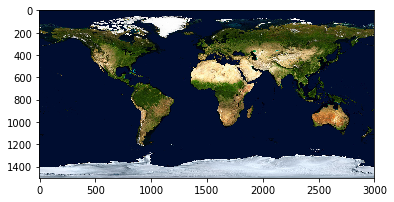

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = np.array(Image.open("world_map.jpg"))
plt.imshow(img)

In [209]:
img.shape

(1500, 3000, 3)

The first dimension is the y coordinate, the second is the x coordinate, and the third is the color specified in RGB.

First, we are going to take the coordinates of each pixel and convert it to the latitude and the longitude in radian. Let $w$ and $h$ be the width and the height of the image. Then the longitude, $\lambda$, and the latitude, $\phi$, in radian of the point $(x, y)$ are

$$
\lambda = \frac{2\pi}{w} \left( x - \frac{w}{2} \right)
$$

$$
\phi = -\frac{\pi}{h} \left( y - \frac{h}{2} \right)
$$

Note here that the y coordinate increases toward the bottom of the image (thus the negative sign for $\phi$).

Now that we have the latitude and the longitude, we can go ahead and calculate the coordinates of the point projected onto the 2d plane.

Imagine a unit sphere in the 3d space with the center at the origin. The north pole of the Earth is at (0, 0, 1) and the south pole at (0, 0, -1). The prime meridian is facing in the direction of the x axis. We will project this sphere onto the 2d plane from the north pole.

The polar coordinates, $(r, \theta)$, of the point on the 2d plane is

$$
(r, \theta) = \left( \tan \left( \frac{\pi}{4}+\frac{\phi}{2} \right), \lambda \right)
$$

The cartesian coordinates, $(x, y)$, is

$$
(x, y) = (r \cos \theta, r \sin \theta)
$$

Finally, we can recover x and y to the original scale by multiplying x by $\frac{w}{2\pi}$ and y by $-\frac{h}{\pi}$.

However, the final image will be a mirror image of the original image. To compensate for this, we can multiply y by -1, so after all we only need to multiply y by $\frac{h}{\pi}$.

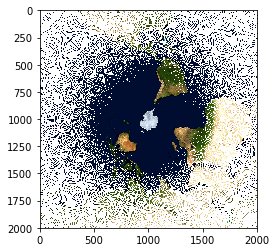

In [4]:
h = img.shape[0]
w = img.shape[1]

x, y = np.array(np.meshgrid(np.arange(0, w, dtype=int), np.arange(0, h, dtype=int), indexing='xy'))

long = 2*np.pi/w * (x - w/2)
lat = -np.pi/h * (y - h/2)

r = np.tan(np.pi/4 + lat/2)

x_new = r * np.cos(long)
y_new = r * np.sin(long)

x_new = np.round(x_new * (w/(2*np.pi)))
y_new = np.round(y_new * (h/np.pi))

# dimension of the image
d = 2000

x_new = np.int_(x_new + d / 2)
y_new = np.int_(y_new + d / 2)

x_new = np.minimum(x_new, d - 1)
y_new = np.minimum(y_new, d - 1)

x_new = np.maximum(x_new, 0)
y_new = np.maximum(y_new, 0)

img_new = np.full((d, d, 3), [255, 255, 255])
img_new[y_new, x_new] = img[y, x]

plt.imshow(img_new)

We have created a beautiful image... of the Antarctica. The pixels get sparse as you move away from the South Pole, and it does not look very good. However, we have verified that our method works!

### Alternative Method


Instead of geographic coordinate system which uses latitude and longitude, we can use spherical coordinate system which uses zenith $\phi$ and azimuth $\theta$.

Then the spherical coordinates, $(\phi, \theta)$, of the coordinates, $(x, y)$, on the image is

$$
(\phi, \theta) = \left( \frac{\pi}{h} y, \frac{2\pi}{w} x - \pi \right)
$$

The polar coordinates, $(R, \Theta)$, of the point projected on to the 2d plane is

$$
(R, \Theta) = \left( \cot \frac{\phi}{2}, \theta \right)
$$

The cartesian coordinates, $(x, y)$, is

$$
(x, y) = (R \cos \Theta, R \sin \Theta)
$$

Finally, we can recover x and y to the original scale by multiplying x by $\frac{w}{2\pi}$ and y by $\frac{h}{\pi}$.

c:\users\2480s\coding\mathar~1\env\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


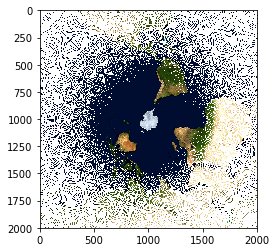

In [5]:
h = img.shape[0]
w = img.shape[1]

x, y = np.array(np.meshgrid(np.arange(0, w, dtype=int), np.arange(0, h, dtype=int), indexing='xy'))

phi = np.pi/h * y
theta = 2*np.pi/w * x - np.pi

r = 1 / np.tan(phi/2)

x_new = r * np.cos(theta)
y_new = r * np.sin(theta)

x_new = np.round(x_new * (w/(2*np.pi)))
y_new = np.round(y_new * (h/np.pi))

# dimension of the image
d = 2000

x_new = np.int_(x_new + d / 2)
y_new = np.int_(y_new + d / 2)

x_new = np.minimum(x_new, d - 1)
y_new = np.minimum(y_new, d - 1)

x_new = np.maximum(x_new, 0)
y_new = np.maximum(y_new, 0)

img_new = np.full((d, d, 3), [255, 255, 255])
img_new[y_new, x_new] = img[y, x]

plt.imshow(img_new)

## Reverse way

Instead of finding where each pixel in the orignal image maps to, we can find where each pixel in the final image comes from. That way, all pixels in the final image will be filled, and it allows us to specify the dimension of the image and how much of the Earth's surface we want it to cover.

Let $d$ be the dimension of the final image and $k$ be the percentage of the Earth's latitude you want to cover, starting from the South Pole. $k$ will take a value between 0 and 1.

|  k  | Latitude |  Location  |
| --- | -------- | ---------- |
|  0  | 90°S     | South Pole |
| .25 | 45°S     |            |
| .5  | 0°       | Equator    |
| .75 | 45°N     |            |
|  1  | 90°N     | North Pole |

The final image will include the area with the latitude between $-\frac{\pi}{2}$ and $k\pi-\frac{\pi}{2}$. The points with the latitude $k\pi-\frac{\pi}{2}$ will be $\tan(\frac{k\pi}{2})$ away from the origin when projected onto the 2d plane, so we want the pixels on the final image to map to a point inside the square whose side is $2\tan(\frac{k\pi}{2})$, centered at the origin. Technically, this region should be a circle, but we want the final image to be a square, so we will just treat it as a square. As a result, the final image will contain some region outside the latitude corresponding to the specified k value.

The point $(x, y)$ on the final image will map to $(x', y')$ on the 2d plane such that

$$
\left( x', y' \right) = \left( \frac{2\tan \left( \frac{k\pi}{2} \right)}{d} \left( x - \frac{d}{2} \right), \frac{2\tan \left( \frac{k\pi}{2} \right)}{d} \left( y - \frac{d}{2} \right) \right)
$$

There should be a negative sign on the y coordinate, but the final image will be a mirror image anyways, so we can leave it as it is.

Next, we will map points on the 2d plane to the surface of the sphere. The longitude, $\lambda$, and the latitude, $\phi$, are

$$
\lambda = \arctan2 \left(y', x' \right)
$$

$$
\phi = 2 \arctan \left(\sqrt{x'^2 + y'^2} \right) - \frac{\pi}{2}
$$

Finally, the coordinate $(x'', y'')$ on the final image is

$$
x'' = \frac{w}{2\pi}(\lambda + \pi)
$$

$$
y'' = \frac{h}{\pi} \left( -\phi + \frac{\pi}{2} \right) = h - \frac{2h}{\pi} \arctan \left( \sqrt{x'^2 + y'^2} \right)
$$

$x''$ and $y''$ will not be whole numbers, so we will round them to the nearest integer. Then, we will take the RGB values at $(x'', y'')$, and plug it into the pixel at $(x, y)$ on the final image.

In [217]:
d = 2000
k = .80

img_original = np.array(Image.open("world_map.jpg"))
h = img_original.shape[0]
w = img_original.shape[1]

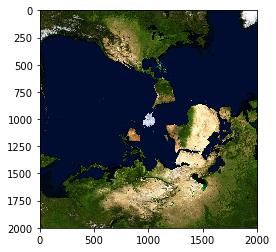

In [227]:
img = np.empty((d, d, 3), dtype=int)

x, y = np.meshgrid(np.arange(0, d), np.arange(0, d), indexing='xy')

factor = 2 * np.tan(k * np.pi / 2) / d
x0 = factor * (x - d/2)
y0 = factor * (y - d/2)

x1 = w/(2*np.pi) * (np.arctan2(y0, x0) + np.pi)
y1 = h - 2*h/np.pi * np.arctan(np.sqrt(np.square(x0) + np.square(y0)))

x1 = np.int_(np.round(x1))
y1 = np.int_(np.round(y1))

x1 = np.maximum(x1, 0)
y1 = np.maximum(y1, 0)

x1 = np.minimum(x1, w - 1)
y1 = np.minimum(y1, h - 1)

img[y, x] = img_original[y1, x1]
plt.imshow(img)

That is indeed a beautiful, great-looking image!

If you want the North Pole at the center, you can just rotate the original image by 180° and repeat the same process.

To make the process easier and reusable, I will make a function that takes the original image, the dimension of the final image, the k value, and the center and returns the final image.

In [212]:
def create_stereographic_projection(img, d, k, center='S'):
    h = img.shape[0]
    w = img.shape[1]

    if center == 'N':
        img = np.flip(np.flip(img, 0), 1)

    x, y = np.meshgrid(np.arange(0, d), np.arange(0, d), indexing='xy')

    factor = 2 * np.tan(k * np.pi / 2) / d
    x0 = factor * (x - d/2)
    y0 = factor * (y - d/2)

    x1 = w/(2*np.pi) * (np.arctan2(y0, x0) + np.pi)
    y1 = h - 2*h/np.pi * np.arctan(np.sqrt(np.square(x0) + np.square(y0)))

    x1 = np.int_(np.round(x1))
    y1 = np.int_(np.round(y1))

    x1 = np.maximum(x1, 0)
    y1 = np.maximum(y1, 0)

    x1 = np.minimum(x1, w - 1)
    y1 = np.minimum(y1, h - 1)
    
    return img[y1, x1]

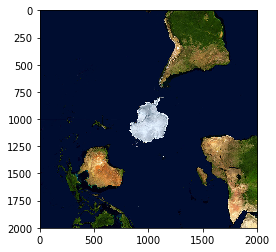

In [213]:
img = create_stereographic_projection(img_original, 2000, .5, 'S')
plt.imshow(img)

### Alternative Method

The point $(x, y)$ on the final image will map to $(x', y')$ on the 2d plane such that

$$
\left( x', y' \right) = \left( \frac{2\tan \left( \frac{k\pi}{2} \right)}{d} \left( x - \frac{d}{2} \right), \frac{2\tan \left( \frac{k\pi}{2} \right)}{d} \left( y - \frac{d}{2} \right) \right)
$$

The spherical coordinate

$$
(\phi, \theta) = \left( 2 \arctan \frac{1}{\sqrt{x'^2 + y'^2}}, \arctan2 \left(y', x' \right) \right)
$$

The cartesian coordinate on the original image

$$
\left( x'', y'' \right) = \left( \frac{w}{2\pi}(\theta + \pi), \frac{h}{\pi} \phi \right)
$$

In [228]:
def create_stereographic_projection(img, d, k, direction='S'):
    h = img.shape[0]
    w = img.shape[1]

    if direction == 'N':
        img = np.flip(np.flip(img, 0), 1)

    x, y = np.meshgrid(np.arange(0, d), np.arange(0, d), indexing='xy')

    factor = 2 * np.tan(k * np.pi / 2) / d
    x0 = factor * (x - d/2)
    y0 = factor * (y - d/2)
    
    phi = 2 * np.arctan(1/np.sqrt(np.square(x0) + np.square(y0)))
    theta = np.arctan2(y0, x0)
    
    x1 = w/(2*np.pi) * (theta + np.pi)
    y1 = h/np.pi * phi

    x1 = np.int_(np.round(x1))
    y1 = np.int_(np.round(y1))

    x1 = np.maximum(x1, 0)
    y1 = np.maximum(y1, 0)

    x1 = np.minimum(x1, w - 1)
    y1 = np.minimum(y1, h - 1)
    
    return img[y1, x1]

c:\users\2480s\coding\mathar~1\env\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


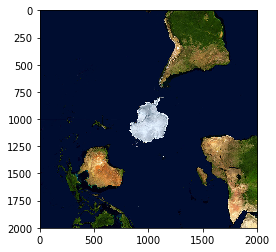

In [229]:
img = create_stereographic_projection(img_original, 2000, .5, 'S')
plt.imshow(img)

## Center other than the South Pole

If we rotate the Earth so that the point with the given latitude and longitude comes to the South Pole and project it onto the 2d plane, the final image will have the specified point at the center.

Conversely, if we rotate the Earth so that the South Pole comes to the given point, we can get the coordinates on the original image.

Before we go into the rotation: to have the North Pole above the center, we will multiply y by -1 to compensate for the increasing y value toward the bottom of the image, and x by -1 to compensate for the mirror image. Now that rotation is involved, we cannot multiply y by -1 for the mirror image or else we will have the South Pole above the center.

Given the central latitude $lat$ and the longitude $long$, the spherical coordinate of the center is

$$
(\phi, \theta) = \left( \frac{\pi}{180} (90 - lat), \frac{\pi}{180} long \right)
$$

In order to bring the South Pole to the specified point, we need to rotate the sphere along the x axis by $\pi - \phi$ counterclockwise and along the z axis by $\frac{\pi}{2} - \theta$ clockwise ($\theta - \frac{\pi}{2}$ counterclockwise).

We will use cartesian coordinates to rotate points. The spherical coordinates $(\phi, \theta)$ is equivalent to

$$
(x, y, z) = (\sin\phi \cos\theta, \sin\phi \sin\theta, \cos\phi)
$$

The rotation matrix by $\theta$ counterclockwise along the x axis is

$$
M_x = \begin{pmatrix}
 1 & 0          & 0 \\
 0 & \cos\theta & -\sin\theta \\
 0 & \sin\theta & \cos\theta\\
\end{pmatrix}
$$

Along the z axis is

$$
M_z = \begin{pmatrix}
 \cos\theta & -\sin\theta & 0 \\
 \sin\theta & \cos\theta  & 0 \\
 0          & 0           & 1\\
\end{pmatrix}
$$

Using these rotation matrices and substituting $\theta$ with appropriate values, we can rotate the Earth.

After the rotation, we need to convert the cartesian coordinates to the spherical coordinates.

$$
(\phi, \theta) = (\arccos z, \arctan2(y, x))
$$

We can scale it appropriately to obtain the coordinates on the original image.

In [4]:
d = 2000
k = .80

img_original = np.array(Image.open("world_map.jpg"))

In [5]:
def to_cartesian(phi, theta):
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return x, y, z

def to_spherical(x, y, z):
    phi = np.arccos(z)
    theta = np.arctan2(y, x)
    return phi, theta

def rotate(v, phi, theta):
    rotation_x = [
        [1, 0, 0],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)]
    ]
    rotation_z = [
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ]
    rotation = np.matmul(rotation_z, rotation_x)
    return np.einsum('ij,klj->kli', rotation, v)
    

def create_stereographic_projection(img, d, k, lat, long):
    h = img.shape[0]
    w = img.shape[1]

    x, y = np.meshgrid(np.arange(0, d), np.arange(0, d), indexing='xy')

    factor = -2 * np.tan(k * np.pi / 2) / d
    x0 = factor * (x - d/2)
    y0 = factor * (y - d/2)
    
    r = np.sqrt(np.square(x0) + np.square(y0))
    
    phi = 2 * np.arctan(1/r)
    theta = np.arctan2(y0, x0)
    
    # rotate
    phi0 = np.pi/180 * (90 - lat)
    theta0 = np.pi/180 * long
    
    x, y, z = to_cartesian(phi, theta)
    
    v = np.dstack((x, y, z))
    v = rotate(v, np.pi - phi0, theta0 - np.pi/2)
    x = v[:,:,0]
    y = v[:,:,1]
    z = v[:,:,2]
    
    phi, theta = to_spherical(x, y, z)
    
    x1 = w/(2*np.pi) * (theta + np.pi)
    y1 = h/np.pi * phi

    x1 = np.int_(np.round(x1))
    y1 = np.int_(np.round(y1))

    x1 = np.maximum(x1, 0)
    y1 = np.maximum(y1, 0)

    x1 = np.minimum(x1, w - 1)
    y1 = np.minimum(y1, h - 1)
    
    return img[y1, x1]

c:\users\2480s\coding\mathar~1\env\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


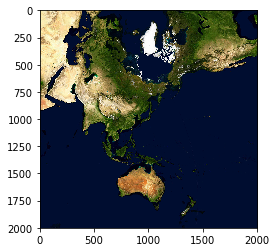

In [6]:
img = create_stereographic_projection(img_original, 2000, .5, 36, 140) # Japan
plt.imshow(img)

## Experiment
Images other than the Earth

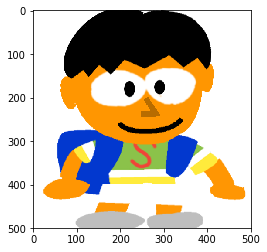

In [14]:
d = 2000
k = .80

img_original = np.array(Image.open("sota.png"))
plt.imshow(img_original)

c:\users\2480s\coding\mathar~1\env\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


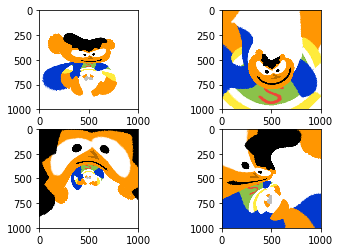

In [19]:
plt.figure()

plt.subplot(221)
plt.imshow(create_stereographic_projection(img_original, 1000, .75, 0, 0))

plt.subplot(222)
plt.imshow(create_stereographic_projection(img_original, 1000, .75, 90, 0))

plt.subplot(223)
plt.imshow(create_stereographic_projection(img_original, 1000, .75, -90, 0))

plt.subplot(224)
plt.imshow(create_stereographic_projection(img_original, 1000, .75, 0, 90))

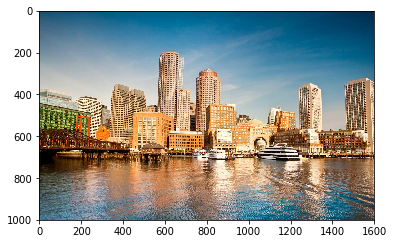

In [20]:
d = 2000
k = .80

img_original = np.array(Image.open("boston.jpg"))
plt.imshow(img_original)

c:\users\2480s\coding\mathar~1\env\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


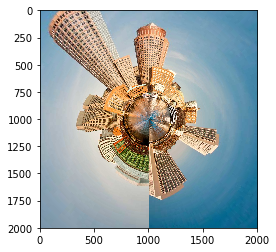

In [21]:
plt.imshow(create_stereographic_projection(img_original, 2000, .75, -90, 0))